In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import operator
import os
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from shutil import copyfile

# keras : librairie de deep learning
import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer, ReLU, AveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Lecture et mise en forme des données

In [16]:
def lecture(path = None, shape = (500,500), proba_train = 0.2, proba_test = .9, color = 'grey'):
    data_train = []
    data_test = []
    if color == 'grey':
        for i in tqdm(os.listdir(path)):
            if i[-3:] == 'png':
                rand = np.random.random()
                if rand <= proba_train:
                    img = Image.open(path + i)
                    data_train.append(np.mean(np.array(img.resize(shape, Image.BILINEAR)), axis=2))

                elif rand >= proba_test:
                    img = Image.open(path + i)
                    data_test.append(np.mean(np.array(img.resize(shape, Image.BILINEAR)), axis=2))
                    
    elif color == 'color':
        for i in tqdm(os.listdir(path)):
            if i[-3:] == 'png':
                rand = np.random.random()
                if rand <= proba_train:
                    img = Image.open(path + i)
                    data_train.append(np.array(img.resize(shape, Image.BILINEAR)))

                elif rand >= proba_test:
                    img = Image.open(path + i)
                    data_test.append(np.array(img.resize(shape, Image.BILINEAR)))
            
    return np.array(data_train), np.array(data_test)

In [74]:
A320_train, A320_test = lecture("G7_scrapping/Airliners/data/Airbus/A320/", (256, 256), color = 'color', proba_train = .3)

In [75]:
A330_train, A330_test = lecture("G7_scrapping/Airliners/data/Airbus/A330/", (256, 256), color = 'color', proba_train = .3)

In [76]:
A350_train, A350_test = lecture("G7_scrapping/Airliners/data/Airbus/A350/", (256, 256), color = 'color', proba_train = .3)

In [77]:
A380_train, A380_test = lecture("G7_scrapping/Airliners/data/Airbus/A380/", (256, 256), color = 'color', proba_train = .3)

In [78]:
Boeing737_train, Boeing737_test = lecture("G7_scrapping/Airliners/data/Boeing/737/", (256, 256), color = 'color', proba_train = .3)

In [79]:
Boeing747_train, Boeing747_test = lecture("G7_scrapping/Airliners/data/Boeing/747/", (256, 256), color = 'color', proba_train = .3)

In [80]:
Boeing767_train, Boeing767_test = lecture("G7_scrapping/Airliners/data/Boeing/767/", (256, 256), color = 'color', proba_train = .3)

In [81]:
Boeing777_train, Boeing777_test = lecture("G7_scrapping/Airliners/data/Boeing/777/", (256, 256), color = 'color', proba_train = .3)

In [82]:
#yBoeing_train  = np.concatenate((np.repeat('Boeing777', len(Boeing777_train)), np.repeat('Boeing767', len(Boeing767_train)), np.repeat('Boeing747', len(Boeing747_train)), np.repeat('Boeing737', len(Boeing737_train))))

In [83]:
yBoeing_train  = np.repeat('Boeing', len(Boeing777_train) + len(Boeing767_train) + len(Boeing747_train) + len(Boeing737_train))

In [84]:
#yAirbus_train  = np.concatenate((np.repeat('A380', len(A380_train)), np.repeat('A350', len(A350_train)), np.repeat('A330', len(A330_train)), np.repeat('A320', len(A320_train))))

In [85]:
yAirbus_train  = np.repeat('Airbus', len(A380_train) + len(A350_train) + len(A330_train) + len(A320_train))

In [86]:
#yBoeing_test = np.concatenate((np.repeat('Boeing777', len(Boeing777_test)), np.repeat('Boeing767', len(Boeing767_test)), np.repeat('Boeing747', len(Boeing747_test)), np.repeat('Boeing737', len(Boeing737_test))))

In [87]:
yBoeing_test  = np.repeat('Boeing', len(Boeing777_test) + len(Boeing767_test) + len(Boeing747_test) + len(Boeing737_test))

In [88]:
#yAirbus_test = np.concatenate((np.repeat('A380', len(A380_test)), np.repeat('A350', len(A350_test)), np.repeat('A330', len(A330_test)), np.repeat('A320', len(A320_test))))

In [89]:
yAirbus_test  = np.repeat('Airbus', len(A380_test) + len(A350_test) + len(A330_test) + len(A320_test))

In [90]:
ytrain = np.concatenate((yAirbus_train, yBoeing_train))

In [91]:
ytrain = pd.get_dummies(pd.Series(ytrain)).values

In [92]:
ytest = np.concatenate((yAirbus_test, yBoeing_test))

In [93]:
ytest = pd.get_dummies(pd.Series(ytest)).values

In [94]:
data_train = np.concatenate((A320_train,A330_train,A350_train,A380_train,Boeing777_train,Boeing767_train,Boeing747_train,Boeing737_train))

In [95]:
data_test = np.concatenate((A320_test,A330_test,A350_test,A380_test,Boeing777_test,Boeing767_test,Boeing747_test,Boeing737_test))

In [96]:
#data_train = np.reshape(data_train, (data_train.shape[0], 224, 224, 1))

In [97]:
#data_test = np.reshape(data_test, (data_test.shape[0], 224, 224, 1))

In [98]:
data_train.shape

(2403, 256, 256, 3)

In [99]:
data_test.shape

(794, 256, 256, 3)

In [100]:
ytrain.shape

(2403, 2)

In [101]:
ytest.shape

(794, 2)

In [102]:
arr = np.arange(ytrain.shape[0])
np.random.shuffle(arr)

ytrain = ytrain[arr]
data_train = data_train[arr]

In [103]:
arr = np.arange(ytest.shape[0])
np.random.shuffle(arr)

ytest = ytest[arr]
data_test = data_test[arr]

In [109]:
ytrain = ytrain[:, 0]
ytest = ytest[:, 0]

# Lecure avec keras

In [12]:
def sep_train_test(new_paths = ['G7_scrapping/Data_train', 'G7_scrapping/Data_test'], path = 'G7_scrapping/Airliners/data', airbus_planes = ['A320', 'A321', 'A350', 'A330'], boeing_planes = ['737', '747', '757', '777'], split_limite = .7):
    for plane in airbus_planes:
        os.makedirs(new_paths[0] + '/' + plane)
        os.makedirs(new_paths[1] + '/' + plane)
        
        for pict in os.listdir(path + '/Airbus/' + plane):
            rand = np.random.random()
            if rand <= split_limite:
                copyfile(path + '/Airbus/' + plane + '/' + pict, new_paths[0] + '/' + plane + '/' + pict)
            else:
                copyfile(path + '/Airbus/' + plane + '/' + pict, new_paths[1] + '/' + plane + '/' + pict)
                
    for plane in boeing_planes:
        os.makedirs(new_paths[0] + '/' + plane)
        os.makedirs(new_paths[1] + '/' + plane)
        
        for pict in os.listdir(path + '/Boeing/' + plane):
            rand = np.random.random()
            if rand <= split_limite:
                copyfile(path + '/Boeing/' + plane + '/' + pict, new_paths[0] + '/' + plane + '/' + pict)
            else:
                copyfile(path + '/Boeing/' + plane + '/' + pict, new_paths[1] + '/' + plane + '/' + pict)

In [13]:
sep_train_test()

In [14]:
from keras.applications.vgg16 import preprocess_input

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

In [16]:
train_generator = train_datagen.flow_from_directory('G7_scrapping/Data_train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 5535 images belonging to 8 classes.


In [17]:
test_generator = train_datagen.flow_from_directory('G7_scrapping/Data_test',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2464 images belonging to 8 classes.


# Modèle Lambda

In [116]:
def create_model(input_shape = (256,256,1), nb_couches = 5, nb_neuronnes = 10, kernel = (3, 3), pool = (2, 2), nb_classes = 1):
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    
    for i in range(nb_couches):
        model.add(Conv2D(2**(nb_neuronnes + i), kernel_size=kernel))
        model.add(keras.layers.BatchNormalization())
        model.add(ReLU())
                  
        model.add(Conv2D(2**(nb_neuronnes + i), kernel_size=kernel))
        model.add(keras.layers.BatchNormalization())
        model.add(ReLU())
        
        model.add(MaxPooling2D(pool_size=pool))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(512))
    model.add(keras.layers.BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(nb_classes, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [117]:
model = create_model(input_shape = (256,256,3), nb_neuronnes = 4)#, nb_classes = ytrain.shape[1])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_82 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
re_lu_82 (ReLU)              (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
batch_normalization_83 (Batc (None, 252, 252, 16)      64        
_________________________________________________________________
re_lu_83 (ReLU)              (None, 252, 252, 16)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 126, 126, 16)     

In [118]:
batch_size = 32
epochs = 5

# Lancement de l'entraînement
history = model.fit(data_train, ytrain, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(data_test, ytest))

Train on 2403 samples, validate on 794 samples
Epoch 1/5
2403/2403 [==============================] - 310s 129ms/step - loss: 0.7931 - accuracy: 0.5734 - val_loss: 0.6665 - val_accuracy: 0.5957
Epoch 2/5
2403/2403 [==============================] - 299s 124ms/step - loss: 0.6023 - accuracy: 0.6787 - val_loss: 0.6893 - val_accuracy: 0.5592
Epoch 3/5
2403/2403 [==============================] - 293s 122ms/step - loss: 0.5261 - accuracy: 0.7399 - val_loss: 0.7679 - val_accuracy: 0.6222
Epoch 4/5
2403/2403 [==============================] - 292s 122ms/step - loss: 0.6316 - accuracy: 0.6633 - val_loss: 10.0990 - val_accuracy: 0.5151
Epoch 5/5
2403/2403 [==============================] - 293s 122ms/step - loss: 0.5147 - accuracy: 0.7511 - val_loss: 1.2679 - val_accuracy: 0.5781


# Transfer learning

In [18]:
from keras.applications.vgg16 import VGG16

In [25]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a global spatial average pooling layer
x = base_model.output



x = Conv2D(256, kernel_size=(3, 3))(x)
x = keras.layers.BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(256, kernel_size=(3, 3))(x)
x = keras.layers.BatchNormalization()(x)
x = ReLU()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(1024)(x)
x = keras.layers.BatchNormalization()(x)
x = ReLU()(x)

x = Dense(512)(x)
x = keras.layers.BatchNormalization()(x)
x = ReLU()(x)

# dernière couche que sert a prédire la bonne classe
predictions = Dense(8, activation = 'softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5,
                   validation_data = test_generator)

Epoch 1/5
153/172 [=========================>....] - ETA: 2:19 - loss: 1.3540 - accuracy: 0.5243

KeyboardInterrupt: 

In [ ]:
## batch_size = 32
epochs = 5

# Lancement de l'entraînement
model.fit(data_train, ytrain, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(data_test, ytest))

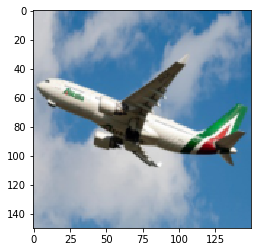

In [36]:
plt.imshow(A330_train[np.random.randint(A330_train.shape[0])])

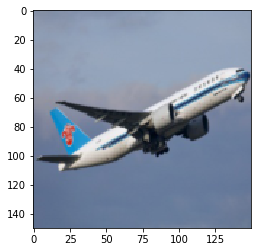

In [37]:
plt.imshow(Boeing777_train[np.random.randint(Boeing777_train.shape[0])])